# Multimodal RAG using ColPali (with Byaldi) and Qwen2-VL

[ColPali](https://huggingface.co/blog/manu/colpali) is a multimodal retriever that removes the need for hefty and brittle document processors. It natively handles images and processes and encodes image patches to be compatible with text, thus removing need to do OCR, or image captioning.

![ColPali](https://cdn-uploads.huggingface.co/production/uploads/60f2e021adf471cbdf8bb660/La8vRJ_dtobqs6WQGKTzB.png)

After indexing data, we will use [Qwen2-VL-7B](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct) to do generation part in RAG.

[Byaldi](https://github.com/AnswerDotAI/byaldi) is a new library by answer.ai to easily use ColPali. This library is in a very early stage, so this notebook will likely be updated soon with API changes.

## Install Byaldi

We will install byaldi from source to get started.

In [1]:
!git clone https://github.com/AnswerDotAI/byaldi.git

Cloning into 'byaldi'...


remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 112 (delta 49), reused 85 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (112/112), 1.97 MiB | 17.35 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [2]:
!sudo apt-get install -y poppler-utils

[sudo] password for bobby: 


In [1]:
%cd byaldi

/home/bobby/Repos/llm_chatbot/byaldi


/home/bobby/Repos/llm_chatbot/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import torch
torch.__version__

'2.4.1+cu121'

In [3]:
!uv pip install -e "."

Resolved 81 packages in 267ms                                        
Uninstalled 1 package in 1ms
Installed 1 package in 2ms                                  
 - fsspec==2024.9.0
 + fsspec==2024.6.1


We need to install transformers from main to get Qwen.

In [4]:
!uv pip install -q pdf2image git+https://github.com/huggingface/transformers.git qwen-vl-utils flash-attn

In [7]:
from huggingface_hub import notebook_login

notebook_login()

Let's see how the PDF looks like.

In [2]:
from pdf2image import convert_from_path
from PIL import Image
# images = convert_from_path("/home/bobby/Repos/llm_chatbot/mag_pic.png")
# images[5]

image = Image.open("/home/bobby/Repos/llm_chatbot/mag_pic.png")
images = [image]

We should initialize `RAGMultiModalModel` object with a ColPali model from Hugging Face. By default this model uses GPU but we are going to have Qwen2-VL in the same GPU so we are loading this in CPU for now.

In [3]:
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained("vidore/colpali")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We can directly index our document using RAG, simply passing pdf file path is enough.

In [4]:
RAG.index(
    input_path="/home/bobby/Repos/llm_chatbot/mag_pic.png",
    index_name="image_index", # index will be saved at index_root/index_name/
    store_collection_with_index=False,
    overwrite=True
)

overwrite is on. Deleting existing index image_index to build a new one.


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Added page 1 of document 0 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index


{0: '/home/bobby/Repos/llm_chatbot/mag_pic.png'}

Now let's retrieve!

In [5]:
text_query = "How much did the world temperature change so far?"
results = RAG.search(text_query, k=1)
results

[{'doc_id': 0, 'page_num': 1, 'score': 18.875, 'metadata': {}, 'base64': None}]

The answer was indeed on page 6, the one we accessed with `images[5]` above.

Now we can actually build a RAG pipeline. For this tutorial we will use Qwen2-VL-7B model.

In [6]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

model = Qwen2VLForConditionalGeneration.from_pretrained("Qwen/Qwen2-VL-2B-Instruct",
                                                        trust_remote_code=True, torch_dtype=torch.bfloat16).cuda().eval()

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", trust_remote_code=True)

image_index = results[0]["page_num"] - 1
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": images[image_index],
            },
            {"type": "text", "text": text_query},
        ],
    }
]

In [8]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [9]:
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [10]:
del RAG
torch.cuda.empty_cache()

In [11]:
generated_ids = model.generate(**inputs, max_new_tokens=50)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)


OutOfMemoryError: CUDA out of memory. Tried to allocate 11.71 GiB. GPU 0 has a total capacity of 23.54 GiB of which 4.63 GiB is free. Including non-PyTorch memory, this process has 18.75 GiB memory in use. Of the allocated memory 17.90 GiB is allocated by PyTorch, and 404.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [57]:
print(output_text)

["The Earth's average global temperature has increased by around 1.1°C since the late 19th century, according to the information provided in the image."]


This is the correct answer!

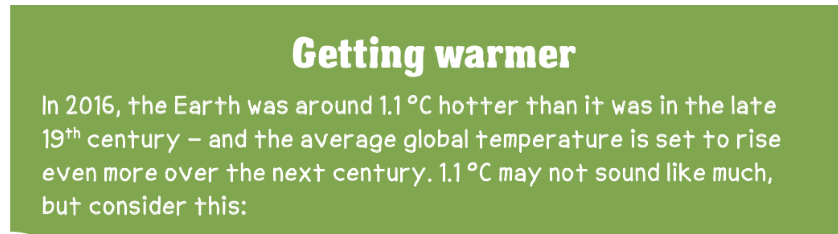